# **Visual Inspection of Motorcycle Connecting Rods**
# Student: Andrea Rossolini

# Id: 0000954735

Students should develop a software system aimed at visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of two different types of connecting rods
to allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
def path_to_dic(img_name_list, folder_path):
  image_dict = {}

  for img_name in img_name_list:
    img = cv2.imread(folder_path+img_name, cv2.IMREAD_GRAYSCALE)
    image_dict[img_name] = img

  return image_dict

def plot_figure_dict(img_dict):
  for k in img_dict:
      plt.title(k)
      plt.imshow(img_dict[k], cmap = 'gray')
      plt.show()

def plot_figures(img_list, title_img = 'fig -', cmap='viridis', figsize=(10,10)):
  plt.figure(figsize=figsize)
  for num, img in enumerate(img_list, start = 1):
    plt.subplot(1,len(img_list), num)
    plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    plt.title(title_img + " " + str(num), fontsize = 15)
  plt.show()

def plot_hist(img_list, title_img = 'Histogram img -', figsize = (20,10), bins = 50):
  plt.figure(figsize=figsize)
  for num, img in enumerate(img_list, start = 1):
    plt.subplot(1,len(img_list), num)
    plt.hist(img.flatten(), bins=bins)
    plt.grid()
    plt.title(title_img + " " + str(num), fontsize = 15)
  plt.show()

The images are loaded in two groupd per each task:
* A list of image paths
* A dictionary with the form of {"file name" : []}

In [3]:
folder_path = r'C:\\Path\\images\\'

first_task_path = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'TESI33.BMP']
first_task_img = path_to_dic(first_task_path, folder_path)

second_task_1 = ['TESI44.BMP', 'TESI47.BMP', 'TESI48.BMP', 'TESI49.BMP']
second_task_1_img = path_to_dic(second_task_1, folder_path)

second_task_2 = ['TESI50.BMP', 'TESI51.BMP']
second_task_2_img = path_to_dic(second_task_2, folder_path)

second_task_3 = ['TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']
second_task_3_img = path_to_dic(second_task_3, folder_path)

# First Task
* **Image characteristics**
1. Images contain only connecting rods, which can be of both types and feature significantly
diverse dimensions.
2. Connecting rods have been carefully placed within the inspection area so to appear well
separated in images (i.e. they do not have any contact point).
3. Images have been taken by the backlighting technique so to render rods easily distinguishable
(i.e. much darker) from background. However, for flexibility reasons the system should not
require any change to work properly with lighting sources of different power.

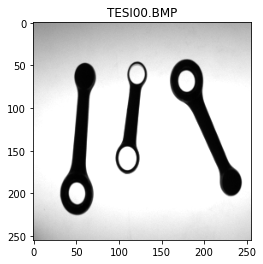

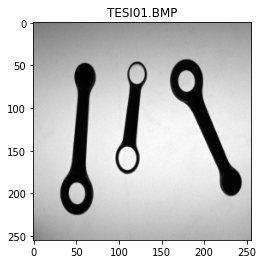

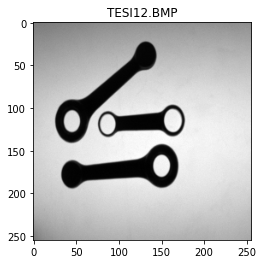

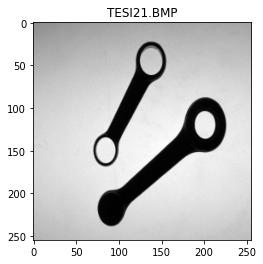

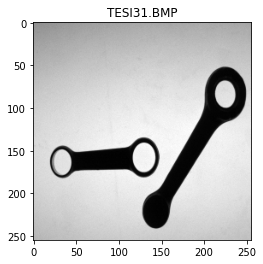

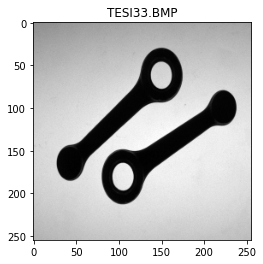

In [4]:
plot_figure_dict(first_task_img)

The following cell shows a function that separate the elements in a binary image. It returns a set of images, where in each of them there is only one element.

To achieve this result, it uses a built in OpenCV function called "connectedComponentsWithStats". This function computes the connected components of a binary image and produces a statistic output for each label.

In [5]:
def separate_rods(bin_image, connectivity = 4):
  '''
  Returns:
    - A set of image of each found element
    - A set of centroid of each found element 
  '''
  _, label_image, stats, centroids = cv2.connectedComponentsWithStats(bin_image, connectivity, cv2.CV_32S)
  rod_idxs= np.unique(label_image)
  background_label = np.argmax(stats[:, 4]) # The background has the largest label
  rod_labels = rod_idxs[rod_idxs != background_label] # remove the background
  rod_images = []
  rod_centroids = []
  for label in rod_labels:
    rod = label_image.copy()
    rod[label_image == label] = 255
    rod[label_image != label] = 0
    rod_images.append(rod)

    rod_centroids.append(centroids[label])
  return [rod_images, rod_centroids]

Image binarization is performed through **OTSU's algorithm**.

The idea behind this algorithm is to segment the image into two maximally homogeneous regions. From this situation, find the optimal threshold that minimizes the gray-level range. This process finds the within-group Variance, which measures the spread of the region intensities after the binarization. 

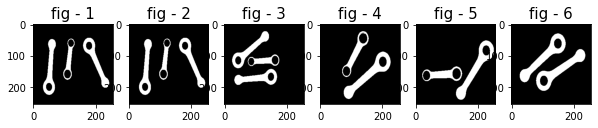

In [6]:
bin_images = []

for k in first_task_img:
  _, bin_image = cv2.threshold(first_task_img[k], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  bin_images.append(bin_image)

plot_figures(bin_images, cmap='gray')

## 1.1. Type of rod
The type of rod represents the number of holes. A rod is typed A if it has 1 hole, type B if it has 2 holes. To compute the number of rods it is possible to perform **second labelling** for each rod image. From the resulting labelling, it is possible to remove the background and the rod itself. From this, we can count the remaining labels. If one label is left, then the rod is type A, if two labels are left, then the rod is type B.

In [7]:
def get_type_from_list(rod_list, connectivity = 4, plot_rod_type = True, print_rod_type = True):
  """
  Input:
   - list of binary images having just one rod each
  Output:
   - Dictionary with {"rod number" : "rod type"}
  """
  type_dict = {}
  for n, rod in enumerate(rod_list):
    holes_rod = np.array(255-rod, dtype=np.uint8)
    _, holes_rod_labelled, _, _ = cv2.connectedComponentsWithStats(holes_rod, connectivity, cv2.CV_32S)

    n_holes = len(np.unique(holes_rod_labelled)) - 2 # remove background and the rod itself

    final_type = "A" if n_holes == 1 else "B" if n_holes == 2 else "NA"

    if plot_rod_type:
      plt.figure()
      plt.title(f"Rod n°{n+1} - type {final_type}")
      plt.imshow(holes_rod_labelled)
      plt.show()

    if print_rod_type:
      print(f"Rod n°{n+1} - type {final_type}")
      
    type_dict[n+1] = final_type
  return type_dict

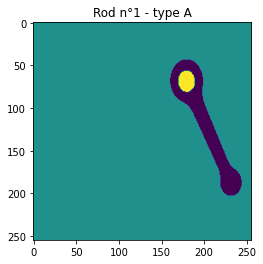

Rod n°1 - type A


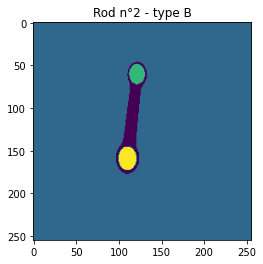

Rod n°2 - type B


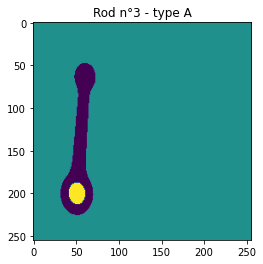

Rod n°3 - type A


{1: 'A', 2: 'B', 3: 'A'}

In [8]:
rod_list = separate_rods(bin_images[0])[0]
get_type_from_list(rod_list, plot_rod_type = True, print_rod_type = True) # compute rods' type

## 1.2. Position and orientation (module $\pi$)
The position of the rod is given by its centroid. The centroid can be easily found using the default OpenCV function "*connectedComponentsWithStats*".

To compute the rod orientation, it is necessary to use the covariance matrix of the image. To derivate the covariance matrix, it is required to use the central moment:
- The central moment is given by:
$$\mu_{pq} = \sum_x\sum_y{(x-\bar{x})^p(y-\bar{y})^qf(x,y)}$$
Where ${\bar{x},\bar{y}}$ are the centroids, $f(x,y)$ the digital image.

- The covariance matrix of the image $I(x,y)$ is given by:
$$cov[I(x,y)] = \left( \begin{array}{cc}
                            \sigma_{ii} & \sigma_{ij} \\
                            \sigma_{ij} & \sigma_{ii}
                        \end{array} \right)
$$
- Where $\sigma^2$ is given by:
$$\sigma_{ii}=\mu_{2,0}/A$$
$$\sigma_{ij}=\mu_{1,1}/A$$
$$\sigma_{jj}=\mu_{0,2}/A$$


In [9]:
def moment(region, m, n):
  height, width = region.shape
  j_coords, i_coords = np.mgrid[:height, :width]
  return (region * i_coords ** m * j_coords ** n).sum()

def central_moment(region, m, n, centroids):
  height, width = region.shape
  j_coords, i_coords = np.mgrid[:height, :width]
  return (region * (i_coords - centroids[0]) ** m * (j_coords - centroids[1]) ** n).sum()

def covariance_matrix(region, centroids):
  area = moment(region, 0, 0)
  sigma_ii = central_moment(region, 2, 0, centroids) / area
  sigma_jj = central_moment(region, 0, 2, centroids) / area
  sigma_ij = central_moment(region, 1, 1, centroids) / area
  return np.array([[sigma_ii, sigma_ij], [sigma_ij, sigma_jj]])

In [10]:
def position_and_orientation(rod_list, centroid_list, is_plot = True):
  '''
  input:
    - list of rods 
    - list of centroids
  returns:
    - Return a couple of dictionaries
      - pos_dict = {"rod number" : rod's centroid} 
      - ori_dict = {"rod number" : rod's orientation}
  '''
  pos_dict = {}
  ori_dict = {}
 
  for n, (rod, centroid) in enumerate(zip(rod_list, centroid_list)):
    # compute the orientation of the rod
    cov_matrix = covariance_matrix(rod, centroid)
    theta = -0.5 * math.atan2((2 * cov_matrix[0, 1]), (cov_matrix[0, 0] - cov_matrix[1, 1]))
    orient = math.degrees(theta)
    # prepare the dictionary to retrun
    pos_dict[n+1] = centroid # passed in input
    ori_dict[n+1] = orient
  
  if is_plot :
    for n, rod in enumerate(rod_list):
      plt.figure()
      plt.title(f"Rod n°{n+1}\n - orientation: {round(ori_dict[n+1],5)}°\n - center: ({round(pos_dict[n+1][0], 3)}, {round(pos_dict[n+1][1], 3)})")
      position = pos_dict[n+1]
      plt.plot(position[0], position[1], 'o')
      plt.imshow(rod, cmap='gray')
      plt.show()
  
  return [pos_dict, ori_dict]

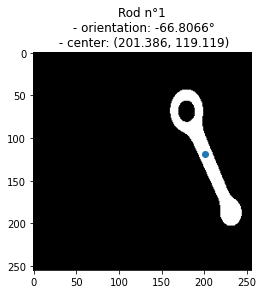

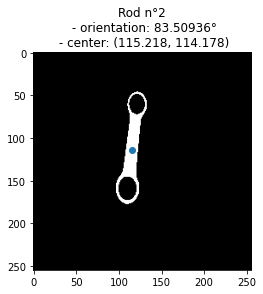

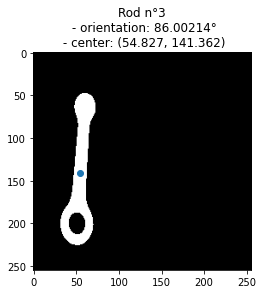

In [11]:
rod_imgs, centroids = separate_rods(bin_images[0])
pos_dict, ori_dict = position_and_orientation(rod_imgs, centroids) # compute position and orientation

# for n, rod in enumerate(rod_imgs):
#     plt.figure()
#     plt.title(f"Rod n°{n+1}\n - orientation: {round(ori_dict[n+1],5)}°\n - center: ({round(pos_dict[n+1][0], 3)}, {round(pos_dict[n+1][1], 3)})")
#     plt.imshow(rod, cmap='gray')
#     position = pos_dict[n+1]
#     plt.plot(position[0], position[1], 'o')

## 1.3. Length ($L$), Width ($W$), Width at the barycenter ($W_B$).

Using the **covariance matrix** from the previous section, we can compute the major and th minor axes of each rod. Indeed, the largest and the smallest eigenvalue of the covariance matrix define the major and minor axes respectively. Using the equation of the major and minor axes, it is possible to compute the **Minimum Enclosing Rectanagle** (MER) of each rod.

Two axes intersect at the barycenter of the rod. It is possible to use one of them to determine the other one and viceversa.
The axes are defined as follows:
$$major\_axis: \alpha x-\beta y -\alpha c_0 + \beta c_1$$
$$minor\_axis: \beta x-\alpha y -\beta c_0 - \alpha c_1$$
Where $\alpha$ and $\beta$ are the eigenvalues of the major and minor axes, $c_0$ and $c_1$ are the rod centroids.

The algorithm consists of computing the MER by finding the intersection between the lines parallel to the major and minor axes. Hence, for each pixel that composes the single rod, we compute the distance from the major and minor axis. In this way we can find the point where the parallel axis should pass by. Once the four axis are found, the vertexes of the MER are the intersection of these lines. 


The **width at the barycenter** is found by computing the distance of the point close to the minor axes, hence to the barycenter

In [12]:
def contact_points(img_bin, major_equation, minor_equation):
    '''
    Inputs:
        - img_bin: binary image 
        - major_equation: numpy array 3x1 representing the major axis equation
        - minor_equation: numpy array 3x1 representing the minor axis equation
    Outputs:
    Returns the contact points between major and minor axes and the contour of the object
    and measure the width at the barycenter
        - maj_a1: on major axis, negative maximum
        - maj_a2: on major axis, positive maximum
        - min_a1: on minor axis, negative maximum
        - min_a2: on minor axis, positive maximum
        barycenter - the width at the barycenter (along the minor axis)
    '''
    # initialize variables
    min_major_distance = math.inf
    max_major_distance = -math.inf
    min_minor_distance = math.inf
    max_minor_distance = -math.inf
    maj_a1 = None
    maj_a2 = None
    min_a1 = None
    min_a2 = None
    min_barycenter_distance = math.inf
    max_barycenter_distance = -math.inf

    # for each point in the image,
    # if the columns move --> change in the horizontal coordinate and vice versa
    for y in range(img_bin.shape[0]):
        for x in range(img_bin.shape[1]):
            if img_bin[y,x] == 255:
                # distance from the major axis as distance of a point to a line
                major_distance = (major_equation[1] * y + major_equation[0] * x + major_equation[2]) / math.sqrt((major_equation[0] ** 2) + (major_equation[1] ** 2))
                # distance from the minor axis as distance of a point to a line
                minor_distance = (minor_equation[1] * y + minor_equation[0] * x + minor_equation[2]) / math.sqrt((minor_equation[0] ** 2) + (minor_equation[1] ** 2))
                
                # update contact points searching for extreme in both horizontal and vertical axes
                if major_distance < min_major_distance:
                    min_major_distance = major_distance
                    maj_a1 = [x, y]
                if major_distance > max_major_distance:
                    max_major_distance = major_distance 
                    maj_a2 = [x, y]
                if minor_distance < min_minor_distance:
                    min_minor_distance = minor_distance
                    min_a1 = [x, y]
                if minor_distance > max_minor_distance:
                    max_minor_distance = minor_distance
                    min_a2 = [x, y]
                
                # if the point is close to the minor axes then it is considered in computing the width at the barycenter
                if abs(minor_distance) < 0.75:
                    # the distances are computed on both directions and summed to obtain the final value
                    if major_distance < min_barycenter_distance:
                        min_barycenter_distance = major_distance
                    if major_distance > max_barycenter_distance:
                        max_barycenter_distance = major_distance
    
    return maj_a1, maj_a2, min_a1, min_a2, abs(min_barycenter_distance) + abs(max_barycenter_distance)

def line_intersection(p1, p2, m1, m2):
    ''' Intersect 2 lines given 2 points and the associated slopes
    Input:
        - p1: (x,y) first line's first point
        - p2: (x,y) second line's first point
        - m1: slope of first line
        - m2: slope of second line
    Output:
        - res: an array containing the intersection point of the two lines if exists, np.nan otherwise
    '''
    if p1 is None or p2 is None or m1 is None or m2 is None:
        raise ValueError("Argument error")
    # prepare the matrices to solve the linear system of equations to find the intersection if there is
    a = np.array([[-m1, 1], [-m2, 1]])
    b = np.array([p1[1] - m1 * p1[0], p2[1] - m2 * p2[0]])
    try:
        res = np.linalg.solve(a, b)
    except:
        res = np.array([np.nan, np.nan])
    return res

In [13]:
def get_sizes(img_bin, rod_list, centroid_list, sizes_round = 2, scale = 20, is_plot = True) :
  '''
  Input: 
   - img_bin: binary image used to plot the result
   - rod_list: list of binary images having just one rod each
   - sizes_round: result precision
   - scale: dimension of the axis in the plot
  Output:
   - sizes: A dictionary of the requested sizes for each rod
            {rod's number : (Length, Width, Width_b)}
  '''
  sizes = {} # {label : (Length, Width, Width_b)}
  for n, (rod, centroid) in enumerate(zip(rod_list, centroid_list), start=1):
    
    # use covariance matrix to find major and minor axes
    cov_matrix = covariance_matrix(rod, centroid)
    # cov = covariance_matrix(rod_image, rods[-1]["centroid"])
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sort_indices = np.argsort(eigenvalues)[::-1]
    major_axes = eigenvectors[:, sort_indices[0]]
    minor_axes = eigenvectors[:, sort_indices[1]]

    alpha = major_axes[1]
    beta = major_axes[0]

    # store major and minor equations
    major_equation = [alpha, - beta, beta * centroid[1] - alpha * centroid[0]]
    minor_equation = [beta, alpha, - beta * centroid[0] - alpha * centroid[1]]

    # find contact points and width at the barycenter
    maj_a1, maj_a2, min_a1, min_a2, barycenter_width = contact_points(rod, major_equation, minor_equation)
    width_b = round(barycenter_width, sizes_round)

    # compute MER vertices
    v1 = line_intersection(maj_a1, min_a1, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
    v2 = line_intersection(maj_a1, min_a2, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
    v3 = line_intersection(maj_a2, min_a1, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])
    v4 = line_intersection(maj_a2, min_a2, -major_equation[0] / major_equation[1], -minor_equation[0] / minor_equation[1])

    # measure length and width
    length = round(math.sqrt(((v1[0] - v2[0])**2) + ((v1[1] - v2[1])**2)), sizes_round)
    width =  round(math.sqrt(((v1[0] - v3[0])**2) + ((v1[1] - v3[1])**2)), sizes_round)

    # result
    sizes[n] = (length, width, width_b)

    if is_plot :
      # MER
      plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color="red")
      plt.plot([v2[0], v4[0]], [v2[1], v4[1]], color="blue")
      plt.plot([v3[0], v1[0]], [v3[1], v1[1]], color="blue")
      plt.plot([v4[0], v3[0]], [v4[1], v3[1]], color="red") 

      # Major and minor axes
      plt.plot([major_axes[0] * - scale * 2 + centroid[0], major_axes[0] * scale * 2 + centroid[0]],
      [major_axes[1] * - scale * 2 + centroid[1], major_axes[1] * scale * 2 + centroid[1]], color='gray')
      plt.plot([minor_axes[0] * - scale + centroid[0], minor_axes[0] * scale + centroid[0]],
      [minor_axes[1] * - scale + centroid[1], minor_axes[1] * scale + centroid[1]], color='gray')
      
      plt.title(f"Rod {n} - MER\n - length: {sizes[n][0]}\n - width: {sizes[n][1]}\n - width_b: {sizes[n][2]}")

      plt.imshow(img_bin, cmap='gray')
      plt.show()

  return sizes

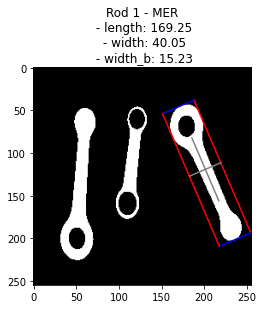

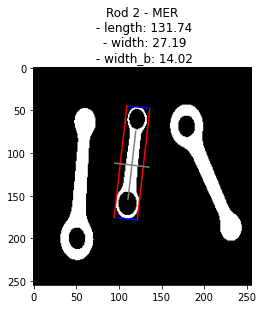

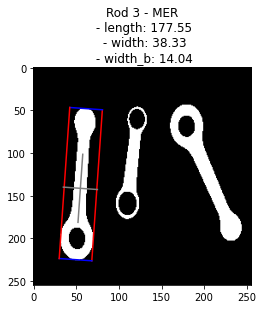

In [14]:
rod_imgs, centroids = separate_rods(bin_images[0])
sizes = get_sizes(bin_images[0], rod_imgs, centroids)

## 1.4. For each hole, position of the centre and diameter size
The "**connectedComponentsWithStats**" function gives all the items to obtain the information we need. Starting from the information generated by the function we exclude those related to the background and the rods them selfes. 

In [15]:
def get_holes_centre_diam(rod_list, connectivity = 4, is_plot = True):
    '''
    Input:
        - rod_list: a list binary images of each single rod
    Output:
        - dict_centres_diameters: a dictionary that stores the information of the rods as follow
                                  {rod number : [[hole centres coord (x, y)], [hole diameters]]}
    '''
    dict_centres_diameters = {} #  {label : [(x,y), (stats)]}
    for n, rod in enumerate(rod_list, start = 1):
        holes_image = np.array(255 - rod, dtype = np.uint8)
        _, holes_labelled, holes_stats, holes_centroid = \
            cv2.connectedComponentsWithStats(holes_image, cv2.CV_32S, connectivity) # obtain the label of the holes for each rod

        background_rods = (
            np.argsort(
                holes_stats[:, 4]
            )[::-1]
        )[0:2]

        final_holes = set(np.unique(holes_labelled)) - set(background_rods) # remove the background and rod from the labelled image

        centres = []
        diamenters = []
        for hole_label in final_holes:
            # compute center and diameter for each hole in rod n
            center = holes_centroid[hole_label]
            radius = holes_stats[hole_label, 4] / math.pi
            diameter = math.sqrt(radius * 2)
            centres.append(center)
            diamenters.append(diameter)
        dict_centres_diameters[n] = [centres, diamenters]

        if is_plot :
            plt.figure()
            title = f"Rod n°{n}\n"
            for k in range(len(dict_centres_diameters[n][1])):
                cntr_x = round(dict_centres_diameters[n][0][k][0], 3)
                cntr_y = round(dict_centres_diameters[n][0][k][1], 3)
                dia    = round(dict_centres_diameters[n][1][k],5)
                title +=  f" - hole {k+1} diameter: {dia}\n - hole {k+1} center: ({cntr_x}, {cntr_y})\n"
                plt.plot(cntr_x, cntr_y, 'o')
            plt.title(title)
            plt.imshow(rod, cmap='gray')
    return dict_centres_diameters

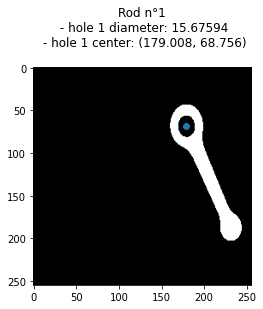

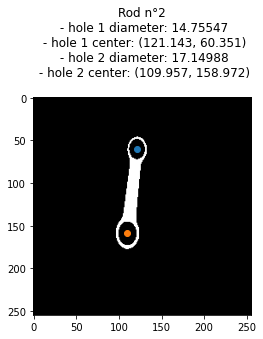

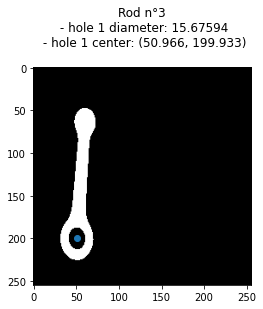

In [16]:
centers_diameter = get_holes_centre_diam(rod_imgs)

### Conclusion task 1
The cells below show how the functions explained above are used all at once.
For each binary image, the functions computes the algorithms in the following order: 
- ```separate_rods``` to obtain the rods that compose the image
- ```get_type_from_list``` to get the type of each rod
- ```position_and_orientation``` to find the center and orientation  of each rod
- ```get_sizes``` to get the size of each rod
- ```get_holes_centre_diam``` to get the info regarding the holes in the rod

In [17]:
def compile_all(bin_image):
    print("____" * 20)
    rod_imgs, centroids = separate_rods(bin_image)
    get_type_from_list(rod_imgs, plot_rod_type = False)
    position_and_orientation(rod_imgs, centroids)

    get_sizes(bin_image, rod_imgs, centroids)
    get_holes_centre_diam(rod_imgs)

________________________________________________________________________________
Rod n°1 - type A
Rod n°2 - type A


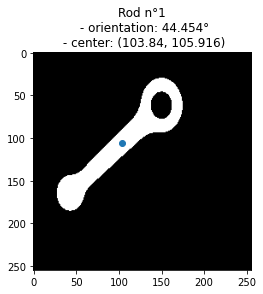

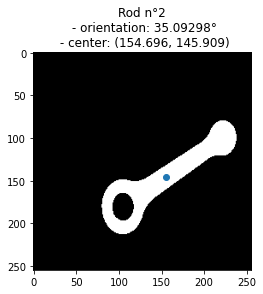

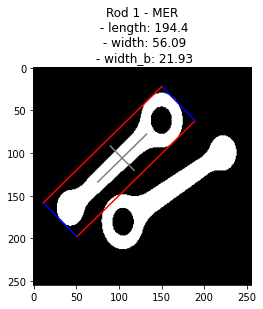

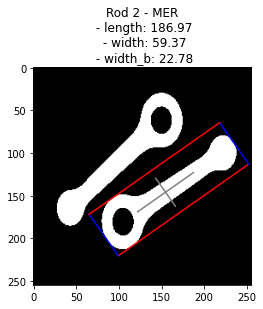

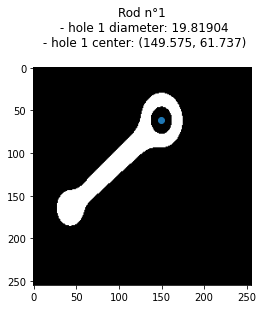

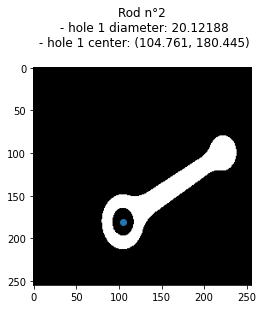

In [18]:
bin_images = []

for k in first_task_img:
  _, bin_image = cv2.threshold(first_task_img[k], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  bin_images.append(bin_image)

compile_all(bin_images[5])

# 2.  Second Task
While still meeting the requirement of the First Task, students should modify the system in order to
deal with one (or more) of the following three changes in the characteristics of the working images:



The following function perform a mean filter over an image. It is used by both sub-task solutions.

In [19]:
def mean_filter_preprocessing(image, size=3, iterations=5):
    prepr_image = image.copy()
    for i in range(0, iterations):
        prepr_image = cv2.medianBlur(prepr_image, size)
    return prepr_image

## 2.1

1. Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”).

This task could be solved using the ```get_type_from_list``` function explained in the first task. Indeed, this function finds if an element has one or two rods; hence, if it has **zero holes**, that element could be classified as a **screw**. Eventually, the washers may result in rods of type A since they have one hole. We can overcome this problem by considering a washer as a **circle**. Hence, computing the difference between the element **width** and** width at the barycenter** they result to be similar. This characteristic may be considered to remove the element. 


Another technique is to use Haralick’s circularity.

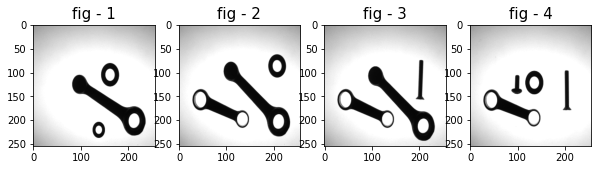

In [20]:
plot_figures(second_task_1_img.values(), cmap='gray')

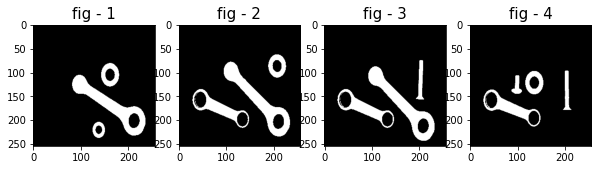

In [21]:
bin_images = []

for k in second_task_1_img:
  _, bin_image = cv2.threshold(second_task_1_img[k], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  bin_images.append(bin_image)

plot_figures(bin_images, cmap='gray')

In [22]:
def separate_rods_by_type(bin_img, debug = False):
    elem_list, centroid_list = separate_rods(bin_img)
    sizes = get_sizes(bin_img, elem_list, centroid_list, is_plot = debug)

    type_dict = get_type_from_list(elem_list,plot_rod_type = debug, print_rod_type = debug)
    get_sizes(bin_img, elem_list, centroid_list, is_plot = debug)

    # n_labels = max(map(max, elem_list))
    n_labels = max(type_dict.keys())
    filtered_img = np.zeros(bin_img.shape, dtype=np.uint8)
    for c in range(0, n_labels):
        i = c + 1
        # if an element has a width similar to the width on the barycenter or has type "NA" gets excluded
        if sizes[i][1] > (sizes[i][2] + 5) and type_dict[i] != "NA":
            filtered_img += np.array(elem_list[c], dtype = np.uint8)
    
    return filtered_img

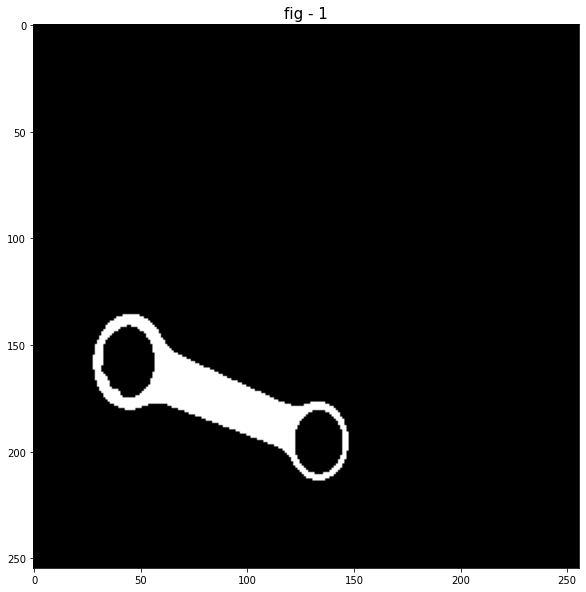

In [23]:
filtered_img = separate_rods_by_type(mean_filter_preprocessing(bin_images[3]))

plot_figures([filtered_img], cmap='gray')

________________________________________________________________________________
Rod n°1 - type B


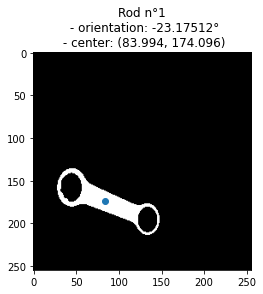

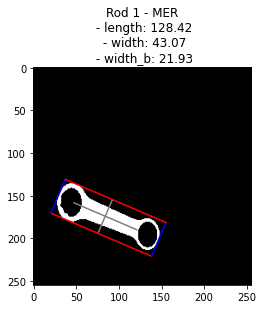

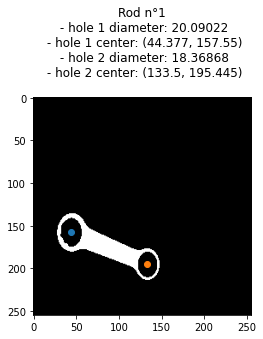

In [24]:
compile_all(mean_filter_preprocessing(filtered_img))

## 2.3.
3. The inspection area may be dirty due to the presence of scattered iron powder.

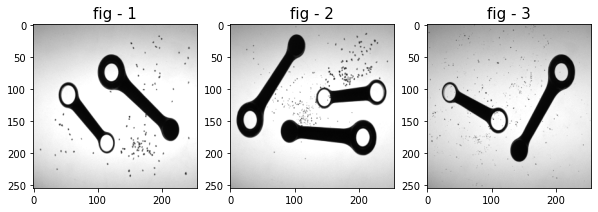

In [25]:
plot_figures(second_task_3_img.values(), cmap = "gray")

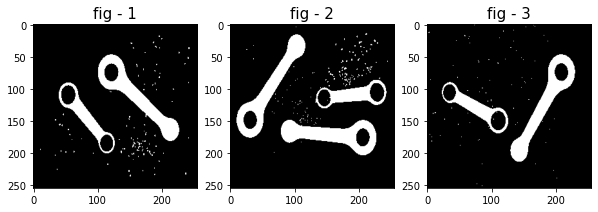

In [26]:
bin_images = []

for k in second_task_3_img:
  _, bin_image = cv2.threshold(second_task_3_img[k], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  bin_images.append(bin_image)

plot_figures(bin_images, cmap='gray')

A **mean filter** on the image is a robust technique to solve the problem. below are shown the results of this method that are effective

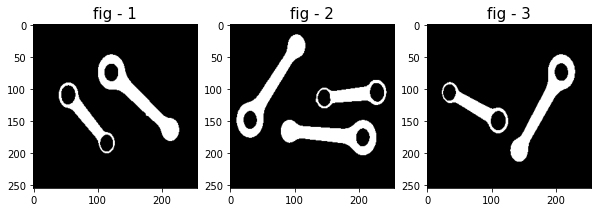

In [27]:
t2_filtered_imgs = []
for bin_img in bin_images:
    filtered_img = mean_filter_preprocessing(bin_img)
    t2_filtered_imgs.append(filtered_img)

plot_figures(t2_filtered_imgs, cmap='gray')

________________________________________________________________________________
Rod n°1 - type A
Rod n°2 - type B


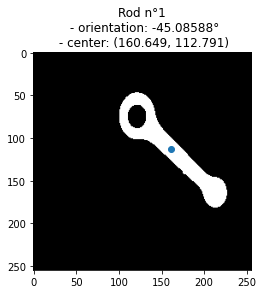

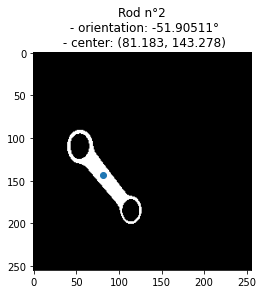

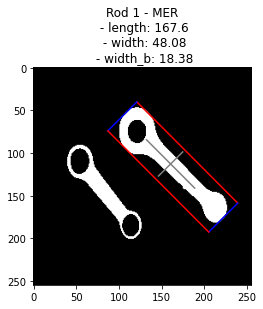

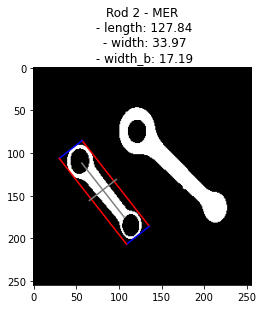

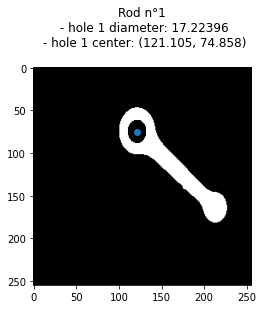

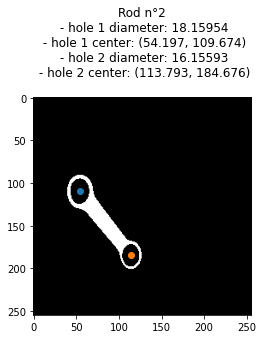

In [28]:
compile_all(t2_filtered_imgs[0])

## 2.2.
2. Rods can have contact points but do not overlap one to another.

*no effective solution has been found for problem number 2.2. Some morphological operations have been tried, but none allowed to separate the rods without ruining their integrity*.